<a href="https://colab.research.google.com/github/BenyaminZojaji/Deep_Learning/blob/main/FaceMask/FaceMaskDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Getting data

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

In [ ]:
%cd /content/gdrive/MyDrive/Dataset/FaceMask

In [12]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Dataset/FaceMask"

In [ ]:
!kaggle datasets download ashishjangra27/face-mask-12k-images-dataset

In [1]:
!unzip -q /content/drive/MyDrive/Dataset/FaceMask/face-mask-12k-images-dataset.zip -d data

### Import libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sn

### Data

In [3]:
train_dataset_path = '/content/data/Face Mask Dataset/Train'
test_dataset_path = '/content/data/Face Mask Dataset/Test'
validation_dataset_path = '/content/data/Face Mask Dataset/Validation'
width = height = 224
batch_size = 32

idg = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip=True,
    brightness_range=(0.8,1.2),
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=20,
    validation_split=0
)
train_data = idg.flow_from_directory(
    train_dataset_path,
    target_size=(width, height),
    class_mode='categorical',
    batch_size=batch_size,
    subset='training'
)

val_data = idg.flow_from_directory(
    validation_dataset_path,
    target_size=(width, height),
    class_mode='categorical',
    batch_size=batch_size,
)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### Vissualization

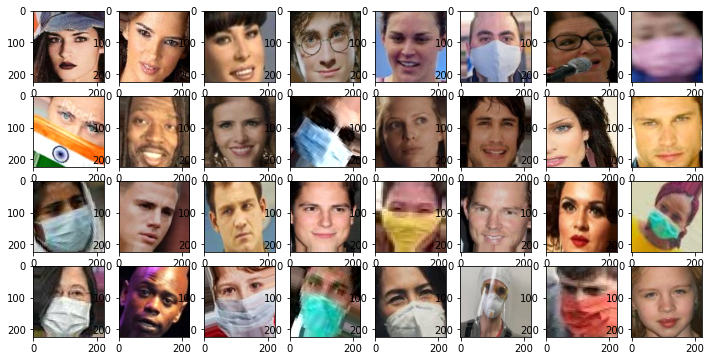

In [10]:
some_images = next(train_data)
X=some_images[0]
Y=some_images[1]

plt.figure(figsize=(12,6))
for i in range(32):
  plt.subplot(4,8,i+1)
  plt.imshow(X[i])

### Model

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    weights="imagenet",
    input_shape=(width,height,3),
    include_top=False,
    pooling='avg'
    )

In [5]:
base_model.trainable = False

In [6]:
model = tf.keras.models.Sequential([
    base_model,
    Dropout(0.2),
    Dense(2, activation="softmax")
])

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
model.fit(train_data, validation_data=val_data, epochs=2)

In [11]:
model.save('MobileNetV2-faceMask.h5')

In [9]:
idg = ImageDataGenerator(
    rescale = 1./255,
)

test_data = idg.flow_from_directory(
    test_dataset_path,
    target_size=(width, height),
    class_mode='categorical',
    batch_size=batch_size,
)

Found 992 images belonging to 2 classes.


In [10]:
model.evaluate(test_data)

31/31 [==============================] - 3s 94ms/step - loss: 0.0257 - accuracy: 0.9929


[0.025668974965810776, 0.992943525314331]

### Confusion Matrix

In [12]:
Y_pred = []

for path in test_data.filepaths:
  try:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (width, height))
    img = img / 255
    img = img.reshape(1, width, height, 3)
    Y_pred.append(np.argmax(model.predict(img)))
  except:
    print(path)#if image isn't readable

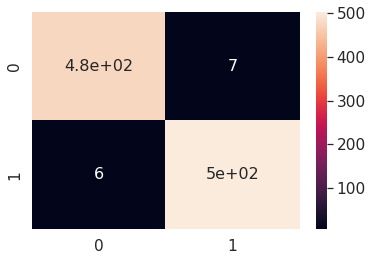

In [15]:
conf_mat = confusion_matrix(test_data.classes, Y_pred)

sn.set(font_scale=1.4) # for label size
sn.heatmap(conf_mat, annot=True, annot_kws={"size": 16})
plt.show()